# Imports needed libraries

In [3]:
from lammps_file_writer import *
from lammps_file_writer import support as sp
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

from scipy.spatial import Delaunay

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(3,2))

/home/hapless/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Imports and starts magcolloids needed functions

In [2]:
sys.path.insert(0, './magcolloids/magcolloids')

import magcolloids.magcolloids as mgc

%load_ext autoreload
%autoreload 2

In [3]:
ureg = mgc.ureg

In [4]:
###Magcolloids section

def initial_setup(packing, height, radius):
    return mgc.initial_setup(150, packing, height, radius)
    
def particles(initial_conditions, radius, susceptibility, diffusion, density, temperature):
    return mgc.particles(
    initial_conditions*ureg.um,
    radius = radius*ureg.um,
    susceptibility = susceptibility,
    diffusion=diffusion*ureg.um**2/ureg.s,
    density = density*ureg.kg/ureg.m**3,
    temperature=temperature*ureg.K)

def field(magnitude, frequency, angle):
    return mgc.field(magnitude = magnitude*ureg.mT, frequency = frequency*ureg.Hz, angle = angle*ureg.degrees)

def world(particles, temperature, region, boundaries, walls, dipoles_cutoff):
    return None
#field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 1*ureg.Hz, angle = 27*ureg.degrees)
#world = mgc.world(particles, temperature = 300*ureg.K,
#                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
#                  dipole_cutoff = 20*ureg.um)

# Pandas data frames functions

In [21]:
##Data frame section

def parse_frame(frame):
    return pd.DataFrame(frame[:,1:], columns = ["type","x","y"], 
                 index = pd.Index(frame[:,0], name = "id"))

def calc_ang_vel(series):
    series[:] = np.unwrap(series)
    return series.diff()
    
def angular_velocity(freq, seed, dir):
    
    trj = sp.read_timesteps(os.path.join(dir,f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))

    trj = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
          keys = trj.keys(), names = ["frame"])

    trh = trj.query("type==2")
    cm = trh.filter(["x","y"]).groupby("frame").mean()

    trj_shift = cm - trj.query("type==2")
    trj_shift = trj_shift.eval("r = sqrt(x**2+y**2)")
    trj_shift["theta"] = np.arctan2(trj_shift["y"], trj_shift["x"])
    trj_shift["theta"] = trj_shift["theta"].where(trj_shift["theta"] >= 0, trj_shift["theta"] + 2 * np.pi)

    
    dt = 1e-2
    trj_shift["v_th"] = trj_shift.groupby("id", group_keys=False).theta.apply(calc_ang_vel).rename("v_th")/dt

    trj_shift = trj_shift.query("frame >= 2500000")

    mean = trj_shift.groupby("frame").mean().v_th

    number_particles = trj_shift.filter(["id"]).query("frame == 0").shape[0]
    std = trj_shift.groupby("frame").std().v_th
    mean_error = std / number_particles ** (1/2)

    global_mean = mean.mean()

    number_frames = len(trj_shift.groupby('frame').size())
    global_error = mean.std() / number_frames ** (1/2) 

    return global_mean, global_error

# Creates ratchet lattice

In [8]:
# Main script
# Define parameters
    
a           = 1  # Lattice constant
radius      = 8.0  # Average radius of the ratchet
saw_amp     = 4.0  # Amplitude of the sawtooth modulation
saw_freq    = 4  # Frequency of the sawtooth pattern
N           = 1000  # Number of points for the ratchet boundary
nx, ny, nz  = 20, 20, 2  # Number of unit cells in each direction
specular    = True ## Flag to permor specular rotation

Kb          = 0.1 #Bond coeff
density     = 0.01 ## Density of the ratchet particles

ratchet_lattice_dir ='./ratchet_lattices/' #directory for storing lattice
ratchet_file_name   = "ratchet_lattice_90.data" #ratchet lattice file name

# Generate lattice
positions = sp.generate_lattice(a, nx, ny, nz, 4.0)
   
# Apply ratchet boundary
filtered_positions = sp.apply_ratchet_boundary(positions, radius, saw_amp, saw_freq, N, specular)
    
# Create bonds
bonds = sp.create_bonds(filtered_positions, a)

#write ratchet data
ratchet_data(a, Kb, density, filtered_positions, bonds, ratchet_lattice_dir, ratchet_file_name)

# Reads series of seeds of file

In [13]:
seeds_file = "./seeds/seeds" 
seeds      = sp.read_seeds(seeds_file)

# Reads series of frequencies of file

In [9]:
frequencies_file = "./frequencies/frequencies"
frequencies      = sp.read_seeds(frequencies_file)

# Creates multiple LAMMPS input files with different seeds and frequencies

In [19]:
input_files_dir     = "./results/tests/" #Directory for storing input files
ratchet_file_name   = "ratchet_lattice.data"        #Ratchet lattice file name that will be used
mag_file_name       = "magcolloids_lattice.data"    #Magcolloids lattice file that will be used
void_radius         = 13                            #Radius of balck space where ratche will be
mag_r               = 1.25                          #Radius of magcolloids particles
ratch_r             = 0.25                          #Radius of ratchet particles
c_eps               = 0.01                          #Magcolloids epsilon constant
cr_eps              = 0.01                          #Magcolloids and ratchet epsilon constant
run                 = 50000000                      #Number of timesteps of simulation

for freq in frequencies:
    
    frequency = freq
    fld = field(magnitude = 7.28, frequency = frequency, angle = 27)

    for seed in seeds:
        
        input_file_name     = "mag_ratchet_" + f"{frequency}Hz" + f"_{seed}" + ".lmpin"
        
        input_file_data(input_files_dir, input_file_name, mag_file_name, ratchet_file_name, void_radius, mag_r, ratch_r, c_eps, cr_eps,
                        vars(fld), seed, run)


# Reads and stores data with Pandas

In [22]:
results_dir = "./results/files_50M/"

velocity_per_freq = np.array([])
error_per_freq = np.array([])
for freq in frequencies:
    
    velocity_per_seed = np.array([])
    error_per_seed = np.array([])
    
    for seed in seeds:
        
        velocity, error = angular_velocity(freq, seed, results_dir)
        velocity_per_seed = np.append(velocity_per_seed, velocity)
        error_per_seed = np.append(error_per_seed, error)
        
    velocity_per_freq = np.append(velocity_per_freq, velocity_per_seed.mean()) 
    error_per_freq = np.append(error_per_freq, velocity_per_seed.std()/(len(velocity_per_seed))**0.5)

# Guardar los arrays
np.save(results_dir+'velocity_per_freq.npy', velocity_per_freq)
np.save(results_dir+'error_per_freq.npy', error_per_freq)

# Lee datos de np file

In [7]:
velocity_per_freq_specular = np.load("./results/files_50M_specular/velocity_per_freq.npy")
velocity_per_freq_normal   = np.load("./results/files_50M/velocity_per_freq.npy")

error_per_freq_specular = np.load("./results/files_50M_specular/error_per_freq.npy")
error_per_freq_normal   = np.load("./results/files_50M/error_per_freq.npy")

# Crea data frame Pandas

In [12]:
data = pd.DataFrame(dict(
    v_up=velocity_per_freq_specular, 
    v_up_error = error_per_freq_specular,
    v_dw=velocity_per_freq_normal,
    v_dw_error = error_per_freq_normal
), index = pd.Index(frequencies, name="frequencies"))

data.to_csv("./results_csv/frequency_vs_velocity.dat", sep = "\t")

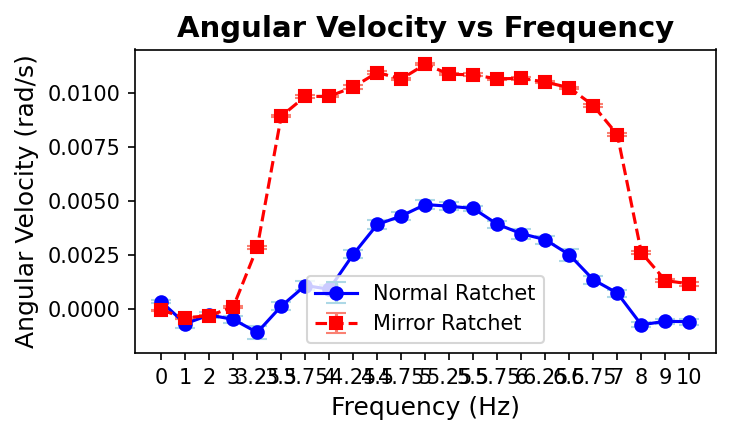

In [6]:
# Tus datos

dir3 = r"/home/hapless/Documents/Projects/week8/files_50M/"
dir4 = r"/home/hapless/Documents/Projects/week8/files_50M_mirror/"

frequencies = read_seeds(dir4+'freqs')

velocity_per_freq_normal = np.load(dir3+'velocity_per_freq.npy')
error_per_freq_normal = np.load(dir3+'error_per_freq.npy')

velocity_per_freq_mirror = np.load(dir4+'velocity_per_freq.npy')
error_per_freq_mirror = np.load(dir4+'error_per_freq.npy')

# Crear una sola figura con un solo eje
plt.figure(figsize=(5, 3))

# Graficar ambos conjuntos de datos en el mismo eje
plt.errorbar(
    frequencies,
    velocity_per_freq_normal,
    yerr=error_per_freq_normal,
    fmt='o-',  # Marcadores circulares con línea continua
    color='blue',
    ecolor='lightblue',  # Color de las barras de error
    capsize=5,     # Tamaño de las líneas horizontales en las barras de error
    label='Normal Ratchet'
)

plt.errorbar(
    frequencies,
    velocity_per_freq_mirror,
    yerr=error_per_freq_mirror,
    fmt='s--',  # Marcadores cuadrados con línea discontinua
    color='red',
    ecolor='salmon',
    capsize=5,
    label='Mirror Ratchet'
)

# Configuración del gráfico
plt.title('Angular Velocity vs Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Angular Velocity (rad/s)', fontsize=12)
#plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Ajustar diseño y mostrar figura
plt.tight_layout()
plt.show()# Tus datos

In [8]:
velocity_per_seed = np.array([])
error_per_seed = np.array([])
frequency = 0

for seed in seeds:
    velocity, error, mean = angular_velocity(frequency, seed, dir4)
    np.save(f"/home/hapless/Documents/Projects/week8/files_50M_mirror/v_freq_{frequency}_seed_{seed}.npy", mean.to_numpy())

NameError: name 'seeds' is not defined

In [ ]:
frames = mean.index.to_numpy()
np.save("/home/hapless/Documents/Projects/week8/files_50M_mirror/frames.npy", frames)

In [ ]:
plt.plot(frames, np.load(f"/home/hapless/Documents/Projects/week8/files_50M_mirror/v_freq_{frequency}_seed_123456.npy"))

In [11]:
seeds = read_seeds(f"/home/hapless/Documents/Projects/week8/files_50M_mirror/seeds")

In [12]:
arrays_list = []
for seed in seeds:
    x = np.load(f"/home/hapless/Documents/Projects/week8/files_50M_mirror/v_freq_{frequency}_seed_{seed}.npy")
    arrays_list.append(x)  # Keep each x as a separate array in a list

mean_array = np.array(arrays_list)  # Convert list to 2D NumPy array

In [13]:
promedio = np.mean(mean_array, axis=0)
promedio

array([-0.00169559,  0.02754584,  0.00581416, ...,  0.00900625,
        0.03325569,  0.00010012], shape=(47501,))

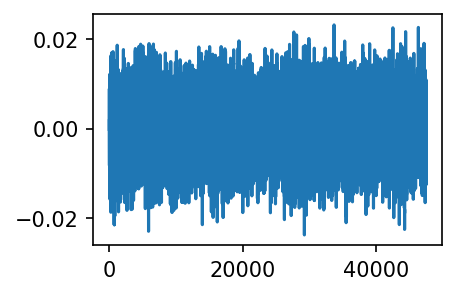

In [22]:
plt.plot(np.convolve(promedio, np.ones(10)/10))


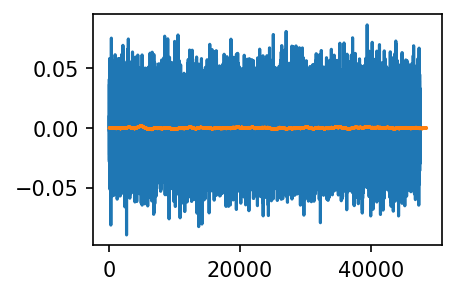

In [26]:
N = 1000
plt.plot(promedio)
plt.plot(np.convolve(promedio, np.ones(N)/N))